In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

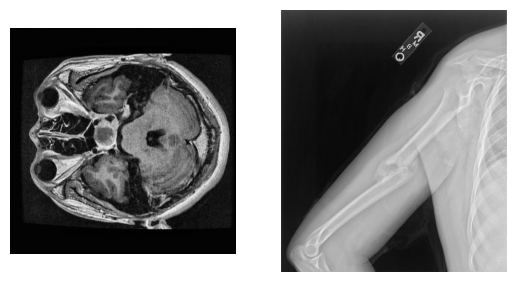

In [3]:
# Đọc ảnh xám
brain_mri = cv2.imread('images/CT_nao_8.jpg', 0)
bone_xquang = cv2.imread('images/Gay_Xuong_3.jpg', 0)

plt.subplot(1,2,1)
plt.imshow(brain_mri, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(bone_xquang, cmap='gray')
plt.axis('off')
plt.show();

In [144]:
# Thêm nhiễu Gaussian vào các ảnh đầu vào
gaussian_noise = np.random.normal(0, 15, brain_mri.shape).astype(np.float32)

brain_mri_noisy = brain_mri.astype(np.float32) + gaussian_noise
brain_mri_noisy = np.clip(brain_mri_noisy, 0, 255).astype(np.uint8)

gaussian_noise = np.random.normal(0, 15, bone_xquang.shape).astype(np.float32)

bone_xquang_noisy = bone_xquang.astype(np.float32) + gaussian_noise
bone_xquang_noisy = np.clip(bone_xquang_noisy, 0, 255).astype(np.uint8)

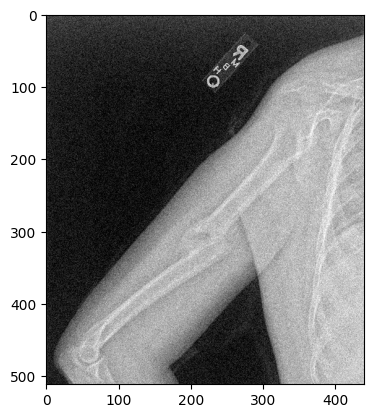

In [145]:
# Hiển thị ảnh gốc sau khi thêm nhiễu
plt.imshow(bone_xquang_noisy, cmap='gray')

In [146]:
# Hàm giảm nhiễu sử dụng phương pháp Gaussian Blur và lọc Gaussian
def Gaussian_noise_reduce(img, kernel_size=3, sigma=3):
    gaussian_kern = cv2.getGaussianKernel(kernel_size, sigma)@cv2.getGaussianKernel(kernel_size, sigma).T
    khu_nhieu_gaussian_kernel = cv2.filter2D(img, -1, gaussian_kern)

    khu_nhieu_gaussian_blur = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

    return {f'Kernel size: {kernel_size}, Sigma: {sigma}': [khu_nhieu_gaussian_kernel, khu_nhieu_gaussian_blur]}

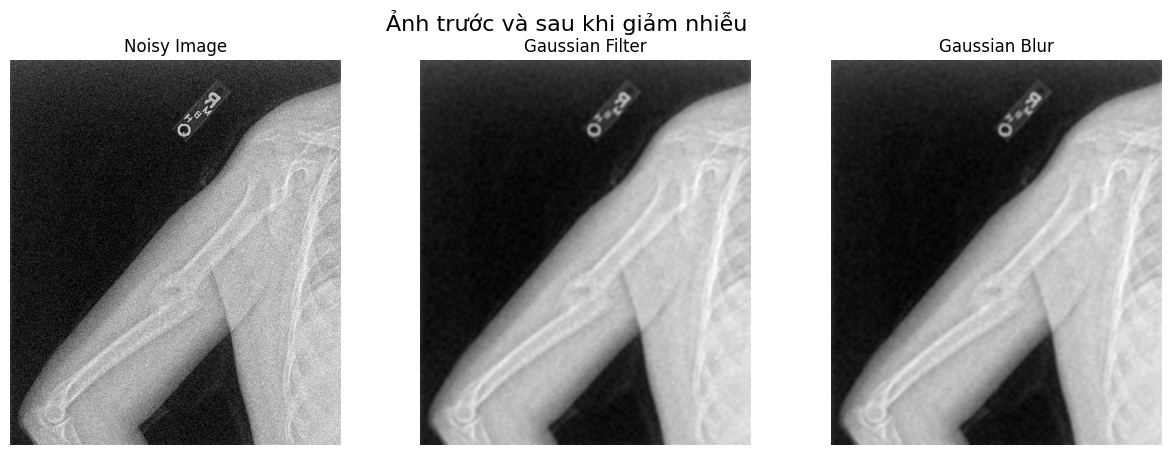

In [147]:
# So sánh ảnh trước và sau khi giảm nhiễu bằng Gaussian Blur và lọc Gaussian
img_noise_reduce = bone_xquang_noisy

results = Gaussian_noise_reduce(img_noise_reduce, kernel_size=5, sigma=6)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Ảnh trước và sau khi giảm nhiễu', fontsize=16)

ax[0].imshow(bone_xquang_noisy, cmap='gray')
ax[0].set_title('Noisy Image')
ax[0].axis('off')

ax[1].imshow(results['Kernel size: 5, Sigma: 6'][0], cmap='gray')
ax[1].set_title('Gaussian Filter')
ax[1].axis('off')

ax[2].imshow(results['Kernel size: 5, Sigma: 6'][1], cmap='gray')
ax[2].set_title('Gaussian Blur')
ax[2].axis('off')

plt.show();

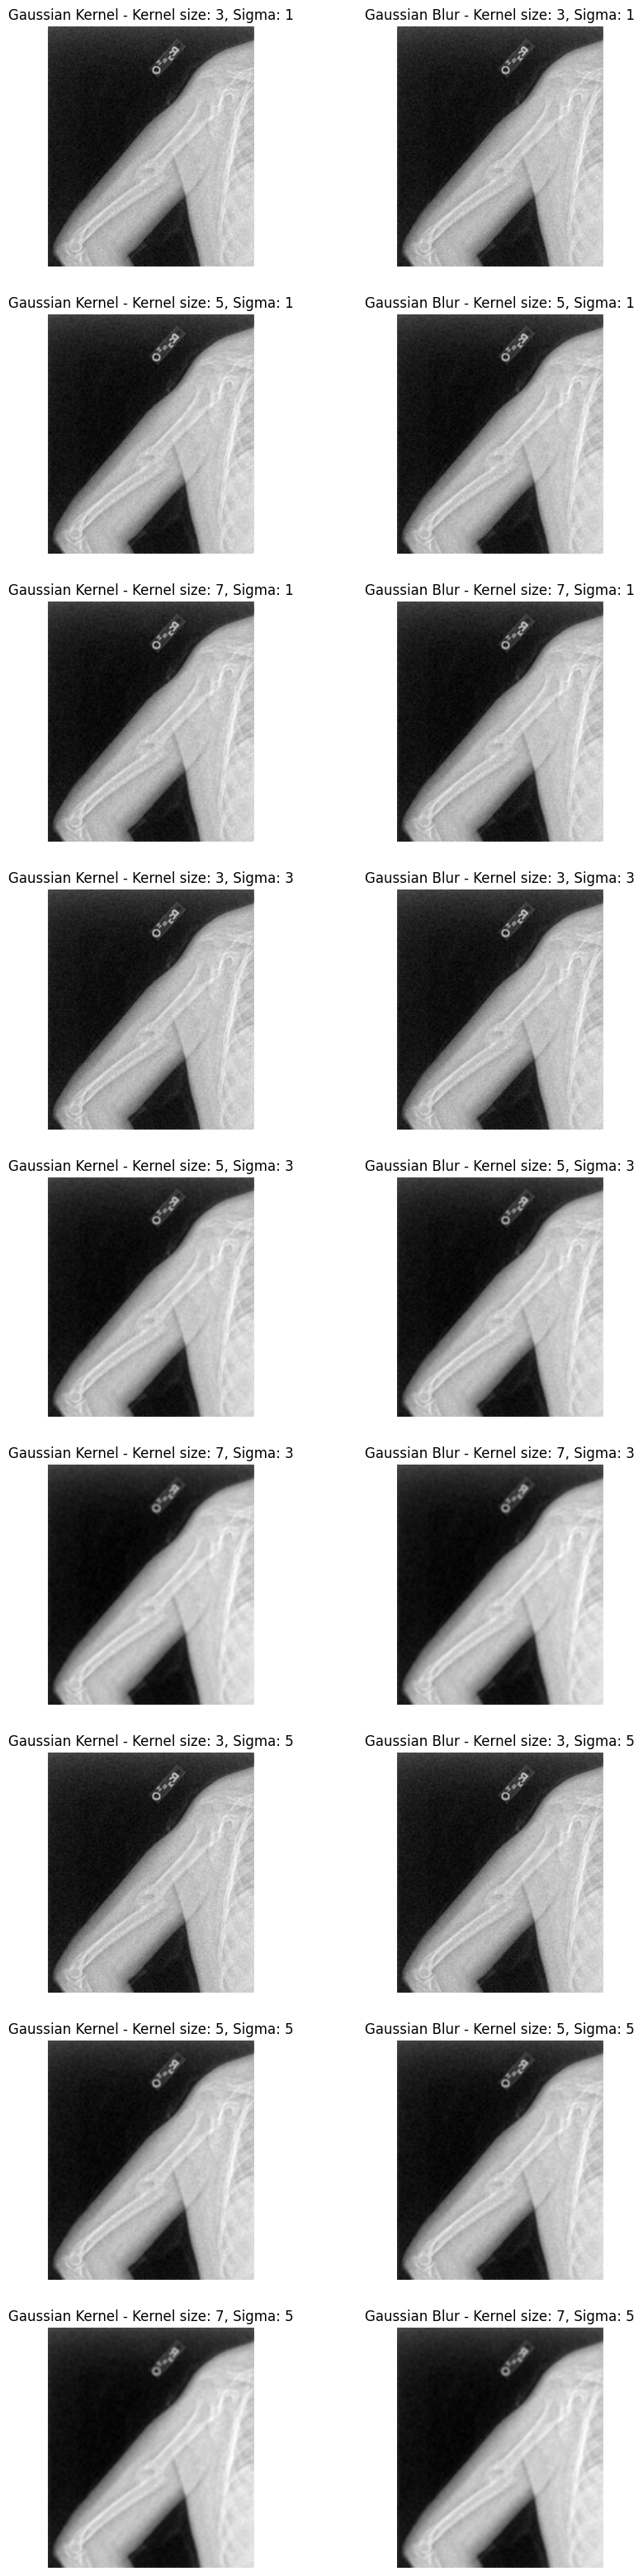

In [148]:
# So sánh kết quả giữa hai phương pháp với các giá trị kernel_size và sigma khác nhau
kernel_sizes = [3, 5, 7]
sigmas = [1, 3, 5]

fig, ax = plt.subplots(9, 2, figsize=(10,40))

for i, sigma in enumerate(sigmas):
    for j, kernel_size in enumerate(kernel_sizes):
        results = Gaussian_noise_reduce(img_noise_reduce, kernel_size, sigma)
        cv2.imwrite(f'out/bone_xquang_noisy_GaussianBlur{kernel_size}_s{sigma}.png', results[f'Kernel size: {kernel_size}, Sigma: {sigma}'][1])
        cv2.imwrite(f'out/bone_xquang_noisy_GaussianKernel{kernel_size}_s{sigma}.png', results[f'Kernel size: {kernel_size}, Sigma: {sigma}'][0])
        for desc, (kernel_result, blur_result) in results.items():
            ax[i*3 + j, 0].imshow(kernel_result, cmap='gray')
            ax[i*3 + j, 0].set_title(f'Gaussian Kernel - {desc}')
            ax[i*3 + j, 0].axis('off')

            ax[i*3 + j, 1].imshow(blur_result, cmap='gray')
            ax[i*3 + j, 1].set_title(f'Gaussian Blur - {desc}')
            ax[i*3 + j, 1].axis('off') 

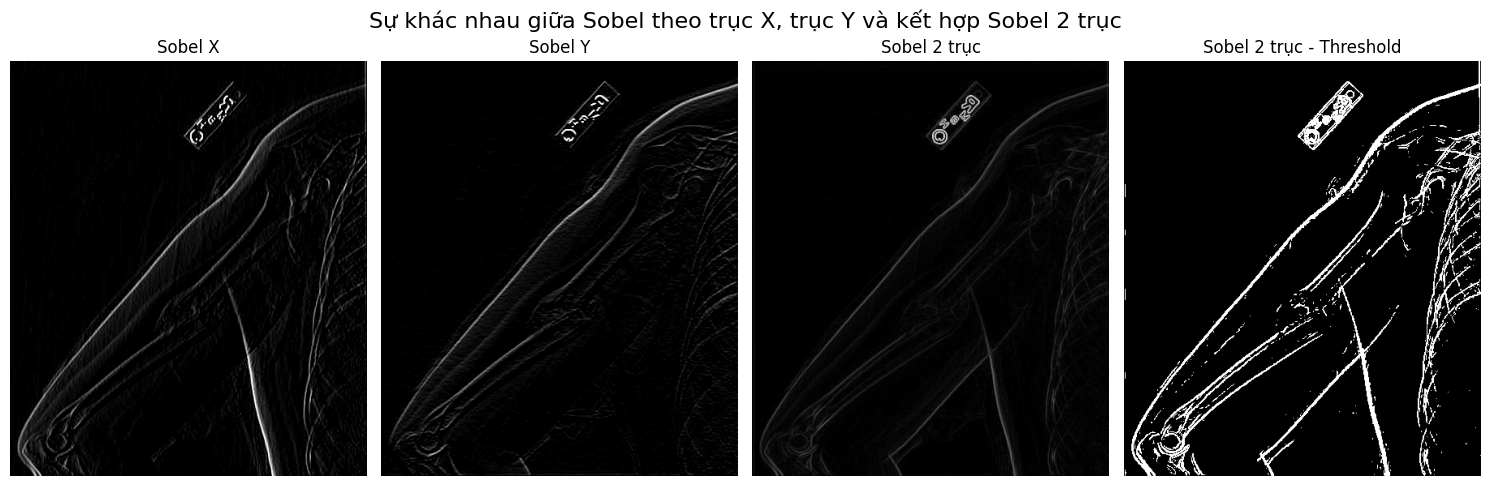

In [149]:
# So sánh sự khác nhau giữa Sobel theo trục X, trục Y và kết hợp Sobel 2 trục
img_bound_recognition = bone_xquang
sobelx = cv2.Sobel(img_bound_recognition, cv2.CV_64F, 1, 0, ksize=3)
sobelx_grayscale = np.clip(sobelx, 0, 255).astype(np.uint8)

sobely = cv2.Sobel(img_bound_recognition, cv2.CV_64F, 0, 1, ksize=3)
sobely_grayscale = np.clip(sobely, 0, 255).astype(np.uint8)

sobel_mag = cv2.magnitude(sobelx, sobely)
sobel_mag_norm = cv2.normalize(sobel_mag, None, 0, 255, cv2.NORM_MINMAX)
sobel_mag_uint8 = sobel_mag_norm.astype(np.uint8)

_, sobel_thresh = cv2.threshold(sobel_mag, 50, 255, cv2.THRESH_BINARY)

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Sự khác nhau giữa Sobel theo trục X, trục Y và kết hợp Sobel 2 trục', fontsize=16)
ax[0].imshow(sobelx_grayscale, cmap='gray')
ax[0].set_title('Sobel X')  
ax[0].axis('off')

ax[1].imshow(sobely_grayscale, cmap='gray')
ax[1].set_title('Sobel Y')
ax[1].axis('off')

ax[2].imshow(sobel_mag_uint8, cmap='gray')
ax[2].set_title('Sobel 2 trục')
ax[2].axis('off')

ax[3].imshow(sobel_thresh, cmap='gray')
ax[3].set_title('Sobel 2 trục - Threshold')
ax[3].axis('off')

plt.tight_layout()
plt.show();

![](images/image1.png)
![](images/image2.png)
![](images/image3.png)
![](images/image4.png)

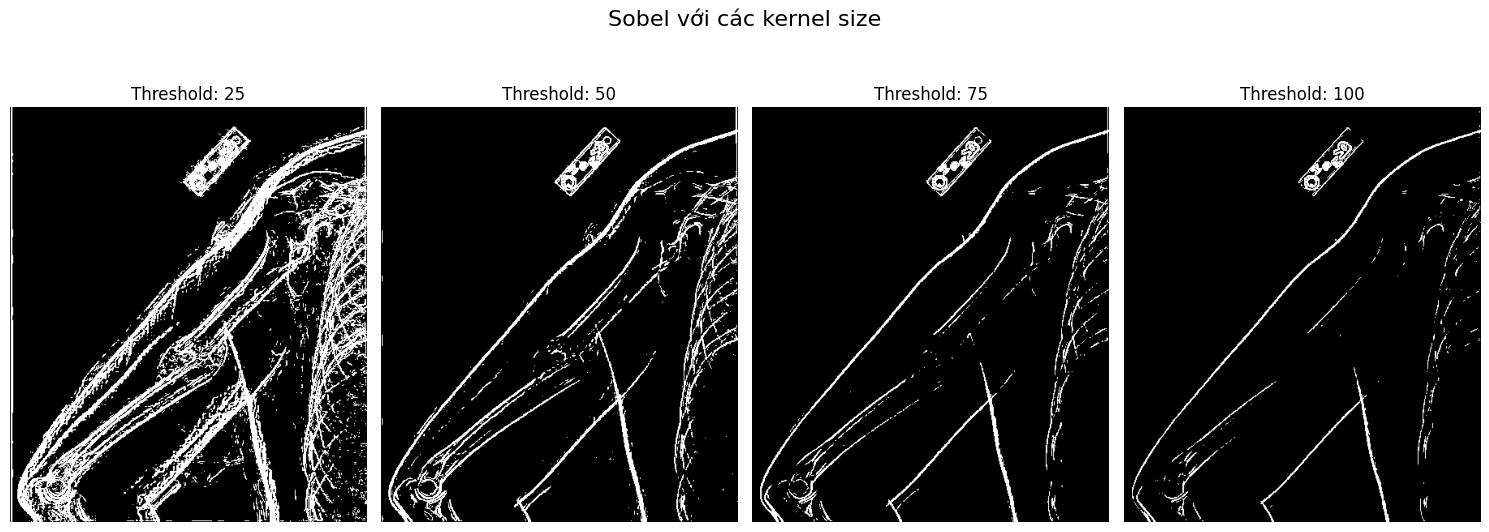

In [154]:
thresholds = [25, 50, 75, 100]

fig, ax = plt.subplots(1, 4, figsize=(15, 6))
fig.suptitle('Sobel với các kernel size', fontsize=16)

for i, threshold in enumerate(thresholds):
    sobelx = cv2.Sobel(img_bound_recognition, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img_bound_recognition, cv2.CV_64F, 0, 1)

    sobel_mag = cv2.magnitude(sobelx, sobely)

    _, sobel_thresh = cv2.threshold(sobel_mag, threshold, 255, cv2.THRESH_BINARY)
    cv2.imwrite(f'out/brain_mri_sobel_mag_threshold{threshold}.png', sobel_thresh)

    ax[i].imshow(sobel_thresh, cmap='gray')
    ax[i].set_title(f'Threshold: {threshold}')
    ax[i].axis('off')

plt.tight_layout()
plt.show();

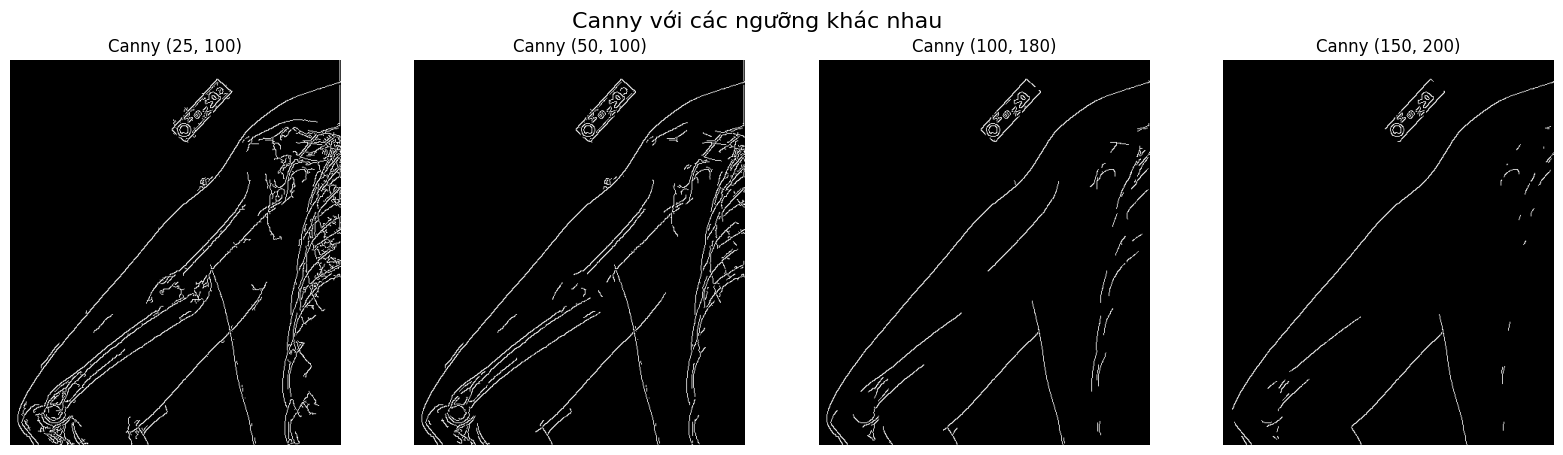

In [155]:
# Sử dụng Canny để phát hiện biên với các ngướng khác nhau
canny = cv2.Canny(bone_xquang, 25, 100)
canny2 = cv2.Canny(bone_xquang, 50, 100)
canny3 = cv2.Canny(bone_xquang, 100, 180)
canny4 = cv2.Canny(bone_xquang, 150, 200)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Canny với các ngưỡng khác nhau', fontsize=16)

ax[0].imshow(canny, cmap='gray')
ax[0].set_title('Canny (25, 100)')
ax[0].axis('off')

ax[1].imshow(canny2, cmap='gray')
ax[1].set_title('Canny (50, 100)')
ax[1].axis('off')

ax[2].imshow(canny3, cmap='gray')
ax[2].set_title('Canny (100, 180)')
ax[2].axis('off')

ax[3].imshow(canny4, cmap='gray')
ax[3].set_title('Canny (150, 200)')
ax[3].axis('off')

plt.show();

Canny phát hiện biên bằng nhiều bước: Gaussian smoothing → tính gradient Sobel → Non-Maximum Suppression → Double Threshold → Hysteresis.

- Non-Maximum Suppression (NMS) giữ lại chỉ những pixel là cực đại theo hướng gradient (tức là đúng đường biên mỏng nhất) vì nếu chỉ dùng magnitude, biên sẽ dày → khó xác định chính xác vị trí.
- Double Threshold:
    + High threshold (T_high): pixel có magnitude > T_high → chắc chắn là biên mạnh.
    + Low threshold (T_low): pixel có magnitude < T_low → bỏ qua (không phải biên).
    + Pixel nằm giữa (T_low ≤ magnitude ≤ T_high) → biên yếu, sẽ xử lý tiếp ở bước sau.
- Edge Tracking by Hysteresis:
    + Các biên yếu chỉ được giữ lại nếu chúng nối liền với biên mạnh.
    + Điều này giúp loại bỏ biên nhiễu rời rạc, nhưng vẫn giữ các biên thật sự liên tục.
    + Kết quả cuối cùng: ảnh biên rõ, liền mạch, ít nhiễu.